# An analysis of the State of the Union speeches - Part 1

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import shelve
import re #for string splitting
import csv #for writing to CSV file

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

This is a "hollowed out" version of my complete analysis, leaving you a few results to check your progress:

In [78]:
speech_metadata = pd.DataFrame(columns = ['President', 'Speech', 'Date', 'Date (String)'])

def read_speech_meta(string): 
    vals = string.split(',')
    d = {}
    d['President'] = vals[0].strip()
    d['Speech'] = vals[1].strip()
    date_string = (vals[2] + vals[3]).strip()
    d['Date'] = datetime.datetime.strptime(date_string, '%B %d %Y')
    d['Date (String)'] = date_string
    return d

'''Custom function designed to read a list of strings that contain 
the speech name, speaker, and date corresponding to a Presidential speech.
Example: ['State of the Union Address', 'George Washington', 'January 8, 1790']'''

def read_speech_meta_list(str_list): 
    d = {}
    d['President'] = str_list[1].strip()
    d['Speech'] = str_list[0].strip()
    date_string = str_list[2].strip()
    d['Date'] = datetime.datetime.strptime(date_string, '%B %d, %Y')
    d['Date (String)'] = date_string
    return d

SEPARATORS = '[\'\":\n\t,-.()%$;?!@#$^&_+=<>/\{}\[\] ]'

'''Removes all occurrences of the empty string from a list of strings'''
def remove_empty_strings(list_of_strings): 
    return list(filter(lambda elem: elem != '', list_of_strings)) 

'''Splits lines according to the SEPARATORS above and the python regex package.
Returns a list of all the words in the speech, with repeats.'''
def split_text_lines(list_of_lines): 
    all_words_with_repeats = []
    for line in list_of_lines: 
        split_line = remove_empty_strings(re.split(SEPARATORS, line))
        all_words_with_repeats += split_line
    return all_words_with_repeats

'''Returns a dictionary whose keys are POSSIBLE_WORDS. The value at each key 
is an integer which is the number of occurrences of that word in WORD_OCURRENCE_LIST'''
def word_count_dict(possible_words, word_occurrence_list): 
    count_dict = dict.fromkeys(possible_words, 0)
    for word in word_occurrence_list: 
        count_dict[word] += 1 
    return count_dict

In [79]:
'''In this cell, we read and organize the data into a CSV file. You can 
run this cell again if you like, but there is no need.'''

np.random.seed(777)

all_unique_words = set()
    
with open('data/stateoftheunion1790-2017.txt', 'r') as g:
    '''First, we ingest the metadata.'''
    f = g.read().split('***') #read only first 10,000 characters of the file to ingest metadata
    meta = f[0].split('\n') #f[0] is the metadata entry. split by line. 
    contents_index = meta.index('CONTENTS') #get the index of the line that indicates the beginning of contents.

    #remove the first few lines, and empty lines
    meta = remove_empty_strings(meta[contents_index + 2:])
    
    #each line has details of a speech. Ingest into the dataframe
    for line in meta: 
        new_series = pd.Series(read_speech_meta(line))
        speech_metadata = speech_metadata.append(new_series, ignore_index=True)
    

    '''We make a first pass through the speeches to create a set of all the unique words used.'''
    for i in range(1, len(f)): 
        current_speech = f[i].lower()
        speech_lines = remove_empty_strings(current_speech.split('\n'))
        
        meta_lines = speech_lines[:3]
        content_lines = speech_lines[3:]
        
        all_speech_words = split_text_lines(content_lines) #this is a list with repeats
        all_unique_words.update(set(all_speech_words)) #cast list to a set and update all_unique_words
    
    '''In our second pass, we write all of the word counts to a CSV file.'''
    with open('data/speech_word_counts.csv', 'w') as csv_file:
        csv_fieldnames = ['President', 'Speech', 'Date', 'Date (String)']
        csv_fieldnames += list(all_unique_words)
        writer = csv.DictWriter(csv_file, fieldnames=csv_fieldnames)
        writer.writeheader()
        for j in range(1, len(f)): 
            current_speech = f[j].lower()
            speech_lines = remove_empty_strings(current_speech.split('\n'))
            
            meta_lines = speech_lines[:3]
            meta_dict = read_speech_meta_list(meta_lines)
            
            content_lines = speech_lines[3:]
            all_speech_words = split_text_lines(content_lines) #this is a list with repeats
            content_dict = word_count_dict(all_unique_words, all_speech_words)
            
            csv_row_dict = {**meta_dict, **content_dict}
            writer.writerow(csv_row_dict)

In [ ]:
all_speeches_df = pd.read_csv('data/speech_word_counts.csv')

In [85]:
import os
os.getcwd()
?io.TextIOWrapper()

Object `io.TextIOWrapper` not found.


Let's take a first look at a high-level summary of what we have so far:

In [35]:
?pd.read_table

In [9]:
# Describe the presidents data


count                       227
unique                       42
top       Franklin D. Roosevelt
freq                         12
Name: president, dtype: object

Let's find the dates of the first and last address, and how much time has passed between those:

In [13]:
# This is roughly the number of years between the first and last address:


227.13210130047912

Let's see during which months are the speeches most frequently delivered:

In [15]:
# This is a count of the number of addresses delivered on any given month
acounts

January       75
February      12
March          0
April          0
May            0
June           0
July           0
August         0
September      2
October        3
November      11
December     124
Name: Address counts, dtype: int64

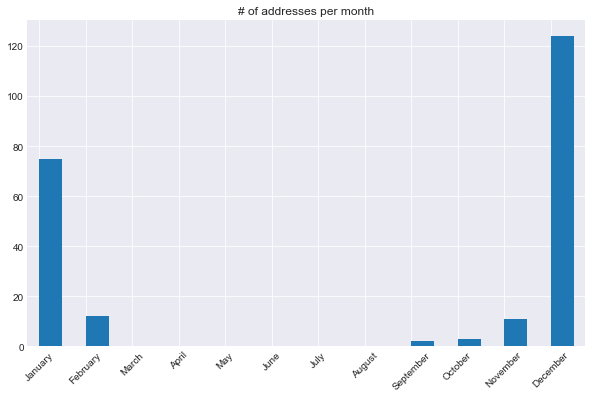

In [16]:
# And this is a plot of these:
plt.savefig('fig/addresses_month.png');

Let's look at the distribution of differences between successive speeches:

Where is the largest gap? We can ask the `ddiff` series for its location:

In [18]:
# this is the index of the largest gap:
dgap

104

Let's look at the dates around this index:

In [19]:
dates[dgap-2 : dgap+2]

102   1891-12-09
103   1892-12-06
104   1897-12-06
105   1898-12-05
Name: date, dtype: datetime64[ns]

As well as a plot of these times:

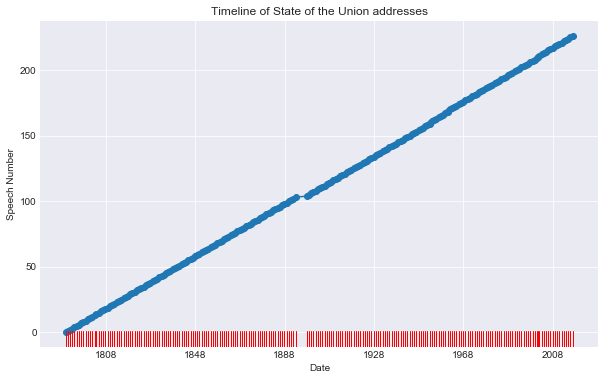

In [20]:
# A plot of the times, along with 'rug' markers on the x axis.
f.savefig('fig/timeline.png')

What happened at that gap?

## Intermediate results

Let's save some intermediate results for further analysis. This lets us work on subsequent notebooks  without rerunning this one.  We use the Pandas HDF5 support for efficient and type-safe serialization of data frames, and the python builtin [shelve](https://docs.python.org/3/library/shelve.html) module for simple Python variables.  We'll create for each notebook variable stores with the notebook number, one for dataframes (`df1.h5`, `df2.h5`, etc.) and one for python variables (`vars1.db`, `vars2.db`, etc.).  These will all go into the `results/` subdirectory.

In [21]:
addresses.to_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    db['speeches'] = speeches